In [1]:
import sys
import os

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from weighted_model.fair_teacher_student_classifier import FairTeacherStudentClassifier
from weighted_model.teacher_student_classifier import TeacherStudentClassifier
from curriculum_models.curriculum_student_teacher import CurriculumStudentTeacher
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
np.random.seed(41) # Set seed for reproducibility

In [2]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("anthonytherrien/synthetic-population-demographics-dataset")

print("Path to dataset files:", path)

# Find the CSV file in the downloaded directory
for file in os.listdir(path):
    if file.endswith(".csv"):
        dataset_path = os.path.join(path, file)
        break

# Read the dataset into a DataFrame
df = pd.read_csv(dataset_path)

# Print the length of the DataFrame
print("Number of rows in the dataset:", len(df))

Path to dataset files: C:\Users\trdin\.cache\kagglehub\datasets\anthonytherrien\synthetic-population-demographics-dataset\versions\1
Number of rows in the dataset: 5000000


In [3]:
df = pd.read_csv(dataset_path)
df.head()

,Name,Gender,Country,Age,Income,Education Level,Occupation,Marital Status,Number of Children,Location Type,Health Index,Exercise Frequency,Diet Quality Score,Credit Score,Car Ownership
0,Любомир Эдгарович Титов,Male,Russia,50,152.0884,Master's,Tech,Divorced,4,Suburban,43.6718,10.0000,6.6544,595.7251,Yes
1,Mercedes Badillo Jurado,Female,Mexico,33,21.3900,Not Finish Highschool,Tech,Divorced,3,Rural,40.0142,3.6052,9.9224,679.9195,Yes
2,鈴木 真綾,Female,Japan,43,12.9380,Master's,Transportation,Married,1,Rural,56.0677,1.1788,4.1207,601.9250,Yes
3,Romil Bora,Female,India,44,33.0745,Bachelor's,Service,Married,0,Urban,41.7896,5.4522,4.9983,724.4884,Yes
4,Krish Grewal,Female,India,41,116.0920,Master's,Administration,Married,3,Urban,37.0245,0.2967,6.9137,640.9269,Yes


In [4]:
df['class'] = df['Income'].apply(lambda x: "<=50K" if x > 50 else ">50K")
df.head()
df = df.drop(columns=['Income'])
df = df.dropna()
df = df.sample(n=200000, random_state=42).reset_index(drop=True)
# TODO for fairness we could me this dataset unfair by removing data for a gender
# for a gender removing only high income data and for another randomly removing data

Gender  class
Female  >50K     0.658173
        <=50K    0.341827
Male    >50K     0.662108
        <=50K    0.337892
Name: proportion, dtype: float64


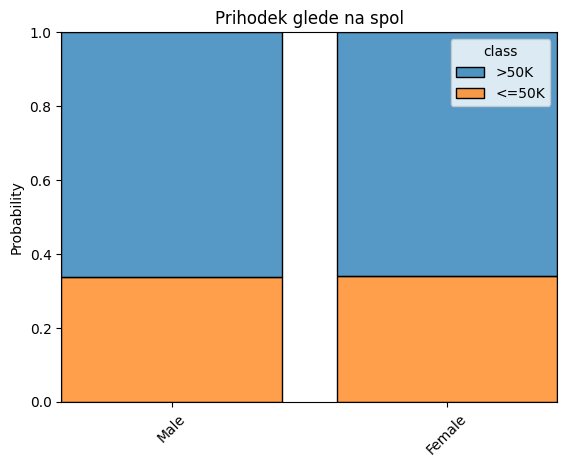

In [ ]:
import matplotlib.pyplot as plt
print(df.groupby('Gender')['class'].value_counts(normalize=True))

sns.histplot(data=df, x='Gender', hue='class', stat='probability', multiple='fill', shrink=.8)
plt.title("Prihodek glede na spol")
plt.xticks(rotation=45)
plt.xlabel(None)
plt.show()

In [ ]:

# Preprocessing: Encode categorical variables
label_encoders = {}
for col in  ['Name', 'Gender', 'Country', 'Education Level', 'Occupation', 
                    'Marital Status', 'Location Type', 'Car Ownership']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['Gender']  # Sensitive attribute

# Train-test split
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2, random_state=42, stratify=y, shuffle=True)


In [ ]:

def split_into_parts(X, y_prob, n_splits = 5):
    """Splits X and y into 5 equal parts and returns them as a list of (X_part, y_part)."""
    split_size = len(X) // n_splits
    
    # Convert probabilities to predictions
    y_pred = np.argmax(y_prob, axis=1)

    split_data = []
    for i in range(n_splits):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < n_splits - 1 else len(X)
        split_data.append((X[start_idx:end_idx], y_pred[start_idx:end_idx]))

    return split_data


In [ ]:
import numpy as np
import pandas as pd

## TODO - Maybe we could teach the model only on easy data or only on hard data

## TODO - Partially Fit then test - then fit again with weights on misslassified samples

def split_into_difficulty_parts(X, y_prob, n_splits=5, ascending=False):
    """Splits X and y into 5 parts based on the highest prediction probability, 
    with the most difficult samples (lowest probability) getting split last.
    """
    split_size = len(X) // n_splits
    
    # Get the maximum probability and corresponding predicted class
    max_prob = np.max(y_prob, axis=1)  # Get highest probability for each sample
    y_pred = np.argmax(y_prob, axis=1)  # Get predicted class labels

    # Combine X (DataFrame), y_pred, and max_prob into a single DataFrame for sorting
    X_sorted = X.copy()  # Work with a copy to avoid modifying original
    X_sorted['y_pred'] = y_pred
    X_sorted['max_prob'] = max_prob
    
    # By default: Sort by the highest probability (descending order) - more confident predictions come first
    X_sorted = X_sorted.sort_values(by='max_prob', ascending=ascending)

    #print(X_sorted.head())    
    # Split the sorted data into n_splits parts
    split_data = []
    for i in range(n_splits):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < n_splits - 1 else len(X_sorted)
        split_X = X_sorted.iloc[start_idx:end_idx].drop(columns=['y_pred', 'max_prob'])  # Drop auxiliary columns
        #print(split_X.head())
        split_y_pred = X_sorted.iloc[start_idx:end_idx]['y_pred']
        split_data.append((split_X, split_y_pred))

    return split_data


In [ ]:
def split_into_difficulty_parts_asc(X, y_prob, n_splits=5):
    return split_into_difficulty_parts(X, y_prob, n_splits, ascending=True)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
print("Creating models ")
curriculum_model = CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = SGDClassifier, transform_func= split_into_parts, split_data=False, n_splits=6)	

difficulty_based_model = CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = SGDClassifier, transform_func= split_into_difficulty_parts, split_data=False, n_splits=6)

diff_asc_model = CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = SGDClassifier, transform_func= split_into_difficulty_parts_asc, split_data=False, n_splits=6)

MulNB_model = CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = MultinomialNB, transform_func= split_into_parts, split_data=False, n_splits=6)
diff_MulNB = CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = MultinomialNB, transform_func= split_into_difficulty_parts, split_data=False, n_splits=6)
diff_asc_MulNB = CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = MultinomialNB, transform_func= split_into_difficulty_parts_asc, split_data=False, n_splits=6)

#Student Teacher models for reference
baseline_model = TeacherStudentClassifier(RandomForestClassifier, split_data=True)

baseline_split = TeacherStudentClassifier(RandomForestClassifier, split_data=True)

#randomForrest for reference
rf_classifier = RandomForestClassifier()

# Train classifiers
print(len(X_train))
print("Starting training")
""" diff_MulNB.fit(X_train, y_train)
diff_asc_MulNB.fit(X_train, y_train)
MulNB_model.fit(X_train, y_train) """
print("finished with MulNB")

diff_asc_model.fit(X_train, y_train)
print("finished with diff_asc_model")
baseline_model.fit(X_train, y_train)
print("finished with baseline_model")
difficulty_based_model.fit(X_train, y_train)
print("finished with difficulty_based_model")
curriculum_model.fit(X_train, y_train)
print("finished with curriculum_model")
baseline_split.fit(X_train, y_train)
rf_classifier.fit(X_train, y_train)
print("finished with training")

# Predicitons with all the models 

""" diff_MulNB_predictions = diff_MulNB.predict(X_test)
diff_asc_MulNB_predictions = diff_asc_MulNB.predict(X_test)
MulNB_model_predictions = MulNB_model.predict(X_test)
 """
diff_asc_model_predictions = diff_asc_model.predict(X_test)
curriculum_model_predictions = curriculum_model.predict(X_test)
difficulty_based_model_predictions = difficulty_based_model.predict(X_test)

baseline_model_predictions= baseline_model.predict(X_test)
baseline_split_predictions = baseline_split.predict(X_test)
rf_predictions = rf_classifier.predict(X_test)

Creating models 
160000
Starting training
finished with MulNB
finished with diff_asc_model
finished with baseline_model
finished with difficulty_based_model
finished with curriculum_model
finished with training


{'diff_asc_model': 0.66015, 'Difficulty Based Model': 0.339825, 'Curriculum Model': 0.33985, 'Baseline Model': 0.66015, 'Baseline Split': 0.66015, 'Random Forest': 0.656725}


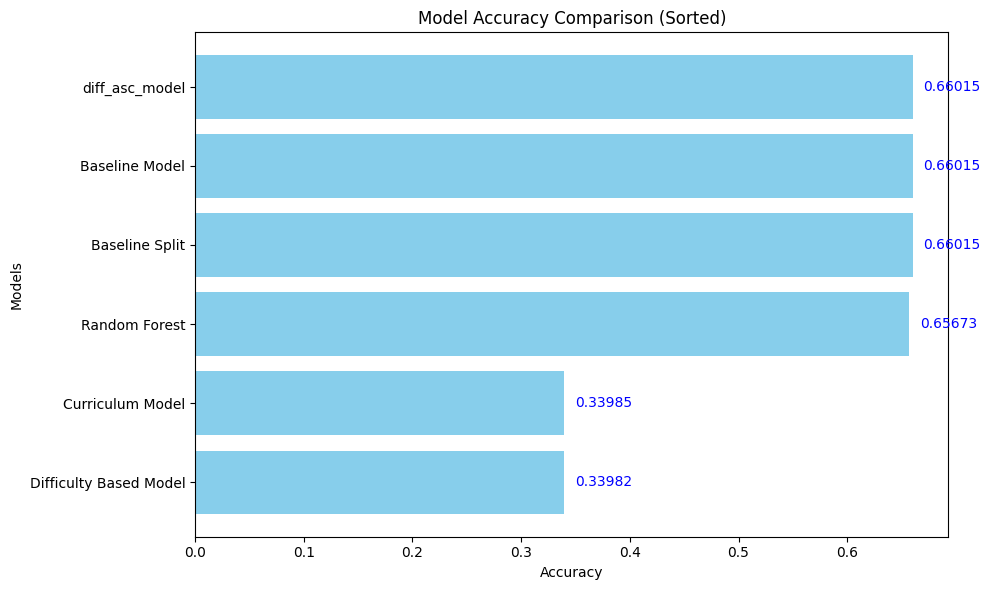

In [ ]:
# Evaluate accuracy for each model
accuracies = {
    "diff_asc_model": accuracy_score(y_test, diff_asc_model_predictions),
    #"diff_MulNB": accuracy_score(y_test, diff_MulNB_predictions),
    #"diff_asc_MulNB": accuracy_score(y_test, diff_asc_MulNB_predictions),
    #"MulNB Model": accuracy_score(y_test, MulNB_model_predictions),
    "Difficulty Based Model": accuracy_score(y_test, difficulty_based_model_predictions),
    "Curriculum Model": accuracy_score(y_test, curriculum_model_predictions),
    "Baseline Model": accuracy_score(y_test, baseline_model_predictions),
    "Baseline Split": accuracy_score(y_test, baseline_split_predictions),
    "Random Forest": accuracy_score(y_test, rf_predictions),
}

print(accuracies)

# Sort models by accuracy
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
models = [item[0] for item in sorted_accuracies]
accuracy_values = [item[1] for item in sorted_accuracies]

# Plot the sorted accuracies
plt.figure(figsize=(10, 6))
plt.barh(models, accuracy_values, color="skyblue")
plt.xlabel("Accuracy")
plt.ylabel("Models")
plt.title("Model Accuracy Comparison (Sorted)")
plt.gca().invert_yaxis()  # Invert y-axis to show highest accuracy at the top
#plt.xlim(0.2, 0.88)


# Annotate bars with accuracy values
for i, v in enumerate(accuracy_values):
    plt.text(v + 0.01, i, f"{v:.5f}", color='blue', va='center')

plt.tight_layout()
plt.show()
